# Inference

In [4]:
import diffusers
from transformers import CLIPVisionModelWithProjection, CLIPImageProcessor
import torch
import cv2
import numpy as np
import os
import random
from tqdm import tqdm
from PIL import Image 

model_path = '/mnt/data/sonia/svd/500hpa_natlantic/'
ckpt_name = ''
real_data_path = '/home/cyclone/train/windmag/500hpa/0.25/natlantic/test'

In [2]:
feature_extractor = CLIPImageProcessor.from_pretrained(os.path.join(model_path, 'feature_extractor'))
image_encoder = CLIPVisionModelWithProjection.from_pretrained(os.path.join(model_path, 'image_encoder'))
scheduler = diffusers.DDPMScheduler.from_pretrained(os.path.join(model_path, 'scheduler'))
unet = diffusers.UNetSpatioTemporalConditionModel.from_pretrained(os.path.join(model_path, ckpt_name, 'unet'))
vae = diffusers.AutoencoderKLTemporalDecoder.from_pretrained(os.path.join(model_path, 'vae'))
pipeline = diffusers.StableVideoDiffusionPipeline.from_pretrained(
    'stabilityai/stable-video-diffusion-img2vid',
    image_encoder=image_encoder,
    vae=vae,
    unet=unet,
    scheduler=scheduler,
    feature_extractor=feature_extractor,
    # revision=args.revision,
)
width = height = 32
num_frames = 8
n = -1 # desired eval set size (-1 for all)

Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00, 1384.99it/s]


In [5]:
outputdir = os.path.join(model_path, ckpt_name, 'synth') #FKA evals
if not os.path.exists(outputdir):
    os.makedirs(outputdir)
    
allexamples = os.listdir(real_data_path)
if n == -1:
    examples = allexamples
else:
    examples = random.sample(allexamples, n)

with open(os.path.join(outputdir, 'examples.txt'), 'w+') as f:
    f.write('\n'.join(examples))
preds = []

pipeline = pipeline.to('cuda')
for example in tqdm(examples):
    imgs = [] 
    for i in range(num_frames):
        frame_path = os.path.join(real_data_path, example, f'{i}.npy')
        img = Image.fromarray(np.load(frame_path))
        img_resized = img.resize((224,224))
        img_tensor = torch.from_numpy(np.array(img_resized)).float()
        img_normalized = img_tensor / 255
        img_normalized = img_normalized.unsqueeze(0).repeat([3,1,1]).unsqueeze(0)  
        imgs.append(img_normalized)
        
    sample = pipeline(
        imgs[0],
        height=height,
        width=width,
        num_frames=num_frames,
        decode_chunk_size=8,
        motion_bucket_id=127,
        fps=7,
        noise_aug_strength=0.02,
    ).frames[0]
    preds.append(sample)
    os.makedirs(os.path.join(outputdir, example), exist_ok=True)
    for i in range(num_frames):
        frame_arr = np.array(sample[i], np.float32).mean(axis=2)
        np.save(os.path.join(outputdir, example, f'{i}'), frame_arr)
pipeline = pipeline.to('cpu')

100%|██████████| 949/949 [15:28<00:00,  1.02it/s]


In [18]:
outputdir

'/mnt/data/sonia/svd/outputs/checkpoint-25000/synth'

In [11]:
pred = [np.asarray(p) for p in preds[0]]

NameError: name 'preds' is not defined

In [29]:
# synthpath = '/home/sonia/cycloneSVD/windmag_atlanticpacific1e-6/checkpoint-50000/synth/checkpoint-50000/19820713180515015500'
synthpath = '/home/sonia/cycloneSVD/windmag_atlanticpacific1e-6/checkpoint-50000/synth/checkpoint-50000/19931120120480013350'
pred = []
for i in range(8):
    frame = np.load(os.path.join(synthpath, f'{i}.npy'))
    pred.append(frame)

In [30]:
# -------- helper to draw black outline & hide ticks --------
def outline_axes(ax, color='k', lw=1.0):
    # ensure frame visible
    ax.set_frame_on(True)
    # black spines
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor(color)
        spine.set_linewidth(lw)
    # no ticks / labels
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False, top=False, left=False, right=False,
        labelbottom=False, labelleft=False
    )

/tmp/ipykernel_120206/2061756574.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = plt.cm.get_cmap('viridis', len(levels) - 1)


164.33333333333334 0.0
100 0 (32, 32)
49 0 (32, 32)
54 0 (32, 32)
89 0 (32, 32)
49 0 (32, 32)
39 0 (32, 32)
32 0 (32, 32)
27 0 (32, 32)


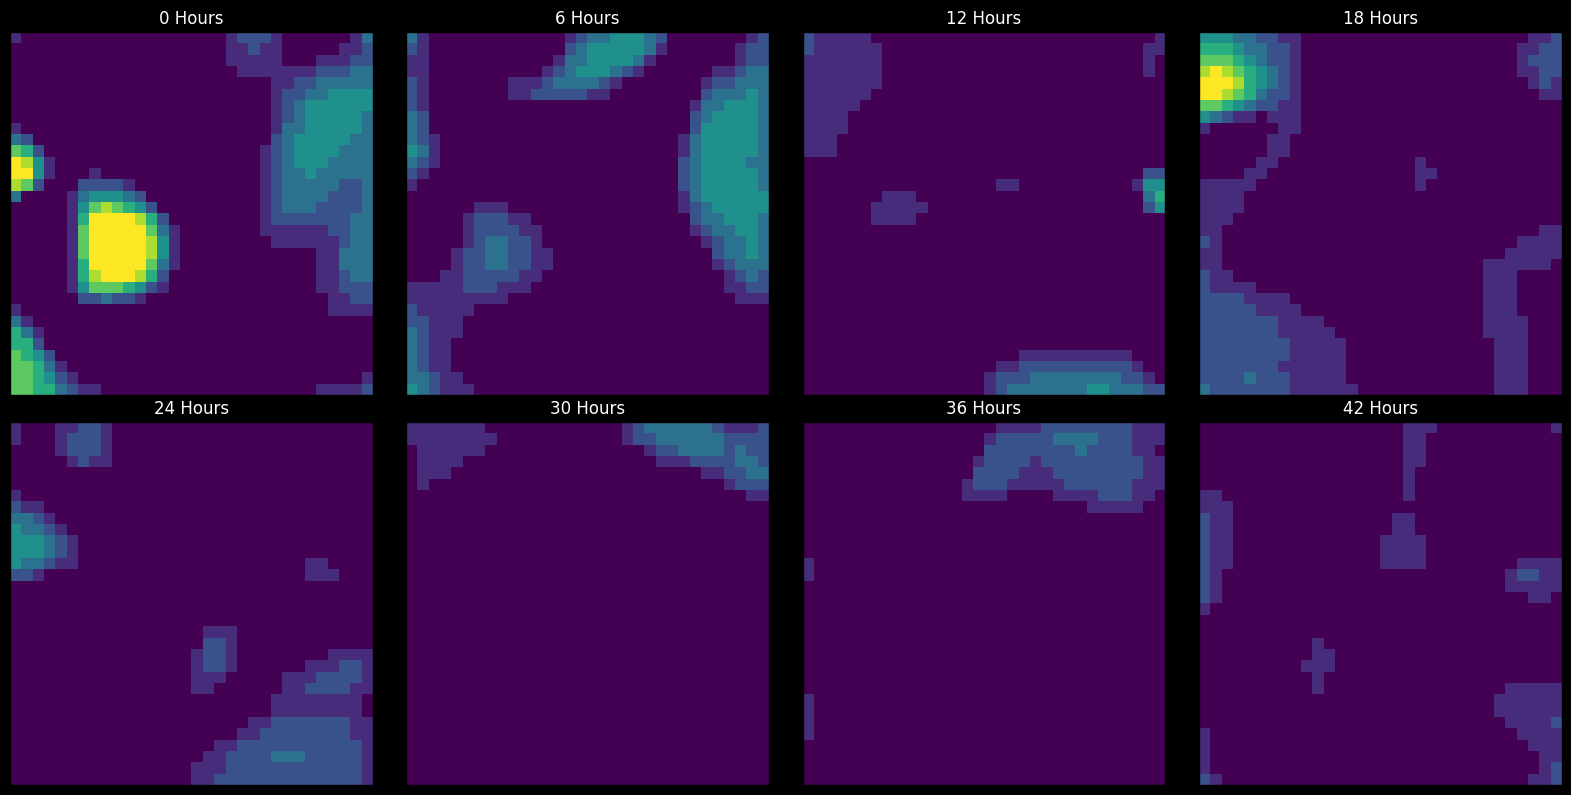

In [31]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Create a figure with 8 subplots (2 rows, 4 columns)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
axes = axes.flatten()  # Flatten to simplify indexing

# 1. Define discrete levels and colormap
levels = list(range(0,100, 10))
# cmap = plt.get_cmap('viridis', len(levels) - 1)
# Start from a discrete viridis
base = plt.cm.get_cmap('viridis', len(levels) - 1)
colors = base(np.arange(base.N))

# Make the first bin (0–10) white
# colors[0] = (1.0, 1.0, 1.0, 1.0)  # RGBA white
# colors[1] = (0.73, 0.87, 1.00, 1.0) 
# colors[2] = (0.50, 0.75, 1.00, 1.0) 
# colors[3] = (0.31, 0.63, 0.96, 1.0) 
# colors[4] = (0.12, 0.61, 0.80, 1.0) 
# colors[5] = (0.00, 0.68, 0.54, 1.0) 
# colors[6] = (0.42, 0.75, 0.29, 1.0) 
# colors[7] = (0.78, 0.84, 0.17, 1.0) 
# colors[8] = (1.00, 0.85, 0.12, 1.0) 

# Build a ListedColormap with modified colors
cmap = mcolors.ListedColormap(colors)

norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
imgs = [img.mean(axis=-1) for img in pred]
maxp = max([np.max(p) for p in imgs])
minp = min([np.min(p) for p in imgs])
print(maxp,minp)

# Load and plot each .npy file
for i in range(8):
    img = imgs[i]
    # img = img - minp # Load the image data
    img = img - minp 
    img = img / (maxp - minp)  # Normalize the image data
    img = 100*img
    img = img.astype(np.uint8)
    print(img.max(), img.min(), img.shape)
    im=axes[i].imshow(img, cmap=cmap, norm=norm)
    axes[i].set_title(f'{i*6} Hours')
    # axes[i].axis('off')  # Hide axes for better display
    outline_axes(axes[i])
    
    
# Add shared colorbar
# cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', ticks=levels,
#                     pad=1, shrink=0.8, fraction=0.05)
# cbar.set_label("Wind Magnitude (m/s)", fontsize=20)
# cbar_ax = fig.add_axes([0.92, 0.15, 0.7, 0.02]) 
# cbar = fig.colorbar(im, cax=cbar_ax,
#                     orientation='horizontal',
#                     pad=0.01, shrink=0.8,
#                     label='Wind Magnitude (m/s)')
# cbar.set_label("Wind Magnitude (m/s)", fontsize=20)
# cbar.ax.tick_params(labelsize=20)
# ticks= list(range(0, int(maxp), int(maxp/9)))
# ticks = [f'{tick:.1f}' for tick in ticks][:-1]
# cbar.set_ticklabels(ticks)

# plt.title('Wind Magnitude Over Time From Storm Detection, 21 January 1988')
# Improve layout and display
plt.tight_layout()
plt.show()


# Eval

In [44]:

import os 
import numpy as np 
realpath = '/home/cyclone/train/windmag_natlantic'

# load all train examples
train=[]
ids = []
for stormdir in sorted(os.listdir(realpath)):
    if not os.path.isdir(os.path.join(realpath, stormdir)) or stormdir=='synth':
        continue
    ids.append(stormdir)
    storm = []
    for i in range(8):
        p = os.path.join(realpath, stormdir, f'{i}.npy')
        img = np.load(p)
        img = np.nan_to_num(img, 0) # replace NAN (missing value) with 0
        storm.append(np.array(img))
    train.append(np.stack(storm))
train = np.stack(train) # concatenate them all together into one matrix
train.shape

(387, 8, 32, 32)

In [45]:
composite=np.mean(train, axis=0) # make a "composite" by averaging over all storms
composite.shape

(8, 32, 32)

In [47]:
composite.mean(), composite.std()

(np.float64(6.233845682705272), np.float64(0.9805870115888183))

In [ ]:
# COMMENTED OUT -- ASSUMES PNG FORMAT BUT NPY FORMAT SYNTHETICS DONT EXIST YET
# load synthetics 
# synth = []
# for stormdir in sorted(os.listdir(synthpath)):
#     if not os.path.isdir(os.path.join(synthpath, stormdir)):
#         continue
#     storm = []
#     for i in range(8):
#         p = os.path.join(synthpath, stormdir, f'{i}.png')
#         img = im.open(p)
#         storm.append(np.array(img))
#     synth.append(np.stack(storm))

/tmp/ipykernel_120206/3264090723.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = plt.cm.get_cmap('viridis', len(levels) - 1)


24.48988787387243 0.24513142934556004
44 0 (32, 32)
46 0 (32, 32)
60 2 (32, 32)
52 0 (32, 32)
70 5 (32, 32)
77 1 (32, 32)
95 1 (32, 32)
100 2 (32, 32)


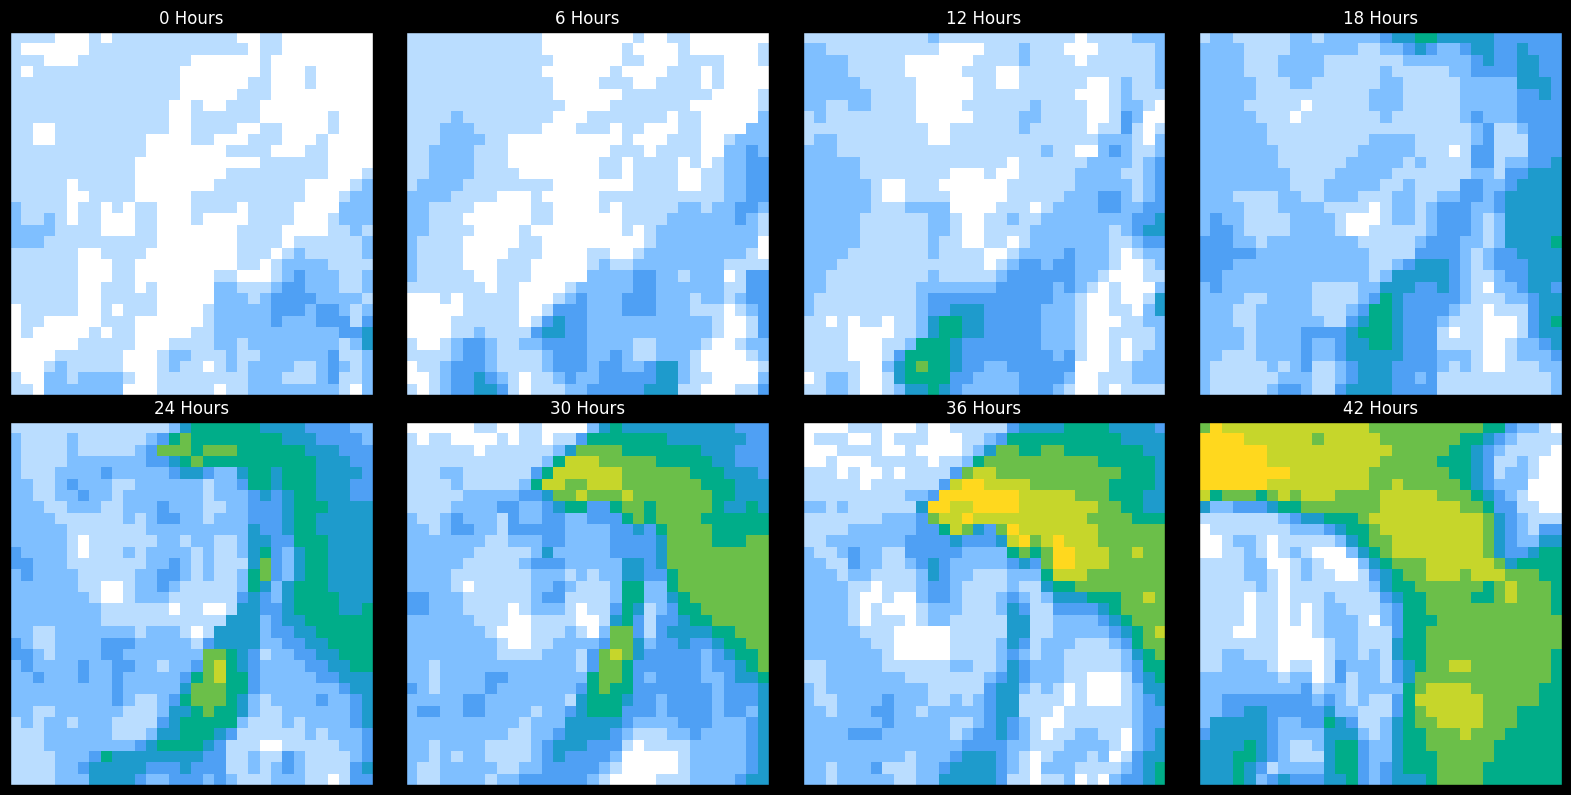

In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
path = '/home/cyclone/train/windmag_atlanticpacific/19880121120440013000'

# Create a figure with 8 subplots (2 rows, 4 columns)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
axes = axes.flatten()  # Flatten to simplify indexing

imgs = []
for i in range(8):
    img = np.load(f'{path}/{i}.npy')  # Load the image data
    if img.ndim == 3:
        img = img.mean(axis=-1)
    imgs.append(img)

# 1. Define discrete levels and colormap
levels = list(range(0,100, 10))
# cmap = plt.get_cmap('viridis', len(levels) - 1)
# Start from a discrete viridis
base = plt.cm.get_cmap('viridis', len(levels) - 1)
colors = base(np.arange(base.N))

# Make the first bin (0–10) white
colors[0] = (1.0, 1.0, 1.0, 1.0)  # RGBA white
colors[1] = (0.73, 0.87, 1.00, 1.0) 
colors[2] = (0.50, 0.75, 1.00, 1.0) 
colors[3] = (0.31, 0.63, 0.96, 1.0) 
colors[4] = (0.12, 0.61, 0.80, 1.0) 
colors[5] = (0.00, 0.68, 0.54, 1.0) 
colors[6] = (0.42, 0.75, 0.29, 1.0) 
colors[7] = (0.78, 0.84, 0.17, 1.0) 
colors[8] = (1.00, 0.85, 0.12, 1.0) 

# Build a ListedColormap with modified colors
cmap = mcolors.ListedColormap(colors)

norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
maxp = max([np.max(p) for p in imgs])
minp = min([np.min(p) for p in imgs])
print(maxp,minp)

# Load and plot each .npy file
for i in range(8):
    img = imgs[i]
    img = imgs[i]
    # img = img - minp # Load the image data
    img = img - minp 
    img = img / (maxp - minp)  # Normalize the image data
    img = 100*img
    img = img.astype(np.uint8)
    print(img.max(), img.min(), img.shape)
    axes[i].imshow(img, cmap=cmap, norm=norm)
    axes[i].set_title(f'{i*6} Hours')
    # axes[i].axis('off')  # Hide axes for better display
    outline_axes(axes[i])

# plt.title('Wind Magnitude Over Time From Storm Detection, 21 January 1988')
# Improve layout and display
plt.tight_layout()
plt.show()


In [31]:
import numpy as np 
np.asarray(img).min(), np.asarray(img).max()

(np.float32(0.84172505), np.float32(24.489887))

# Pretrain inference

In [1]:
import diffusers
from diffusers import DiffusionPipeline
from transformers import CLIPVisionModelWithProjection, CLIPImageProcessor
import torch
import cv2
import numpy as np
import os
import random
from tqdm import tqdm
from PIL import Image 

model_path = '/home/sonia/cycloneSVD/img1e-8/'
real_data_path = '/home/cyclone/train/windmag_atlanticpacific'

/home/sonia/miniconda3/envs/svd/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
unet = diffusers.UNet2DConditionModel.from_pretrained(
    model_path, subfolder="unet", revision="main"
)
unet = unet.eval()

In [20]:
cross_attention_dim = 768
zeros = torch.zeros(1, 1, cross_attention_dim) #16=train batch size

class CondDiffusionPipeline(DiffusionPipeline):
    def __init__(self, unet, scheduler):
        super().__init__()
        self.register_modules(unet=unet, scheduler=scheduler)
        self.unet = unet 
        self.scheduler = scheduler 
        
    @torch.no_grad()
    def __call__(self, batch_size=1, generator=None, encoder_hidden_states=None, **kwargs):
        device = self.unet.device
        sample  = torch.randn(
            batch_size, self.unet.config['out_channels'], 32, 32,
            generator=generator, device=device
        )
        
        self.scheduler.set_timesteps(1000)
        
        for t in self.scheduler.timesteps:
            eps = self.unet(sample, t, encoder_hidden_states=encoder_hidden_states)
            sample = self.scheduler.step(eps.sample, t, sample).prev_sample
            
        return {"images": sample.cpu()}

In [21]:
noise_scheduler = diffusers.DDPMScheduler.from_config(model_path, subfolder="scheduler", revision="main")
pipeline = CondDiffusionPipeline(unet=unet, scheduler=noise_scheduler)
images = pipeline(
    batch_size=1,
    generator=torch.Generator().manual_seed(0), 
    encoder_hidden_states=zeros,
    # Use a separate torch generator to avoid rewinding the random state of the main training loop
)['images']

/home/sonia/miniconda3/envs/svd/lib/python3.11/site-packages/diffusers/configuration_utils.py:250: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


In [25]:
sample  = torch.randn(
    1, unet.config['out_channels'], 32, 32,
    generator=torch.Generator().manual_seed(0)
)
for t in noise_scheduler.timesteps:
    eps = unet(sample, t, encoder_hidden_states=zeros)
    sample = noise_scheduler.step(eps.sample, t, sample).prev_sample

In [29]:
sample.shape

torch.Size([1, 1, 32, 32])

In [28]:
dict(eps).keys()

dict_keys(['sample'])

/tmp/ipykernel_419178/1773793997.py:3: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(img, mode='L').resize((100,100))


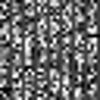

In [ ]:
img = (images[0]+1) * 255/2
img = img.squeeze().numpy()
Image.fromarray(img, mode='L').resize((100,100))